# Logistic Regression from Scratch
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ritchieng/deep-learning-wizard/blob/master/docs/deep_learning/fromscratch/fromscratch_logistic_regression.ipynb)

This is an implementation of a simple logistic regression for binary class labels. We will be attempting to classify 2 flowers based on their petal width and height: setosa and versicolor.

## Imports

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from collections import Counter

## Preparing a custom 2-class IRIS dataset

### Load Data

In [0]:
# Instantiate dataset class and assign to object
iris = datasets.load_iris()

# Load features and target
# Take only 2 classes, and 2 features (sepal length/width)
X = iris.data[:-50, :2]
# For teaching the math rather than preprocessing techniques,
# we'll be using this simple scaling method. However, you must
# be cautious to scale your training/testing sets subsequently.
X = preprocessing.scale(X)
y = iris.target[:-50] 

### Print Data Details

In [0]:
# 50 of each iris flower
print(Counter(y))

# Type of flower
print(list(iris.target_names[:-1]))

# Shape of features
print(X.shape)

Counter({0: 50, 1: 50})
['setosa', 'versicolor']
(100, 2)


### Scatterplot 2 Classes

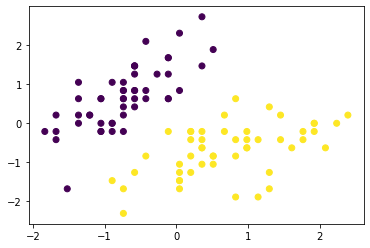

In [0]:
plt.scatter(X[:, 0], X[:, 1], c=y);

### Train/Test Split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f'X train size: {X_train.shape}')
print(f'X test size: {X_test.shape}')
print(f'y train size: {y_train.shape}')
print(f'y test size: {y_test.shape}')

# Distribution of both classes are roughly equal using train_test_split function
print(Counter(y_train))

X train size: (80, 2)
X test size: (20, 2)
y train size: (80,)
y test size: (20,)
Counter({0: 41, 1: 39})


## Math

### 1. Forwardpropagation
- **Get our logits and probabilities**
- Affine function/transformation: $z = \theta x + b$
- Sigmoid/logistic function: $\hat y = \frac{1}{1 + e^{-z}}$

### 2. Backwardpropagation
- **Calculate gradients / partial derivatives w.r.t. weights and bias**
- Loss: $L = ylog(\hat y) + (1-y) log (1 - \hat y)$
- Partial derivative of loss w.r.t weights: $\frac{\delta L}{\delta w} =\frac{\delta L}{\delta z} \frac{\delta z}{\delta w} = (\hat y - y)(x^T)$
- Partial derivative of loss w.r.t. bias: $\frac{\delta L}{\delta b} = \frac{\delta L}{\delta z} \frac{\delta z}{\delta b} = (\hat y - y)(1)$
    - $\frac{\delta L}{\delta z} = \hat y - y$
    - $\frac{\delta z}{\delta w} = x$
    - $\frac{\delta z}{\delta b} = 1$

#### 2a. Loss function clarification
- Actually, why is our loss equation $L = ylog(\hat y) + (1-y) log (1 - \hat y)$?
    - We have given the intuition in the [Logistic Regression tutorial](https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_logistic_regression/#cross-entropy-function-d-for-2-class) on why it works.
    - Here we will cover the derivation which essentially is merely maximizing the log likelihood of the parameters (maximizing the probability of our predicted output given our input and parameters
    - Given:
        - $\hat y = \frac{1}{1 + e^{-z}}$.
    - Then:
        - $P(y=1 \mid x;\theta) = \hat y$
        - $P(y=0 \mid x;\theta) = 1 - \hat y$
    - Simplified further:
        - $p(y \mid x; \theta) = (\hat y)^y(1 - \hat y)^{1-y}$
    - Given m training samples, the likelihood of the parameters is simply the product of probabilities:
        - $L(\theta) = \displaystyle \prod_{i=1}^{m} p(y^i \mid x^i; \theta)$
        - $L(\theta) = \displaystyle \prod_{i=1}^{m} (\hat y^{i})^{y^i}(1 - \hat y^{i})^{1-y^{i}}$
        - Essentially, we want to maximize the probability of our ouput given our input and parameters
    - But it's easier to maximize the log likelihood, so we take the natural logarithm. 
        - $L(\theta) = \displaystyle \sum_{i=1}^{m} y^{i}log (\hat y^{i}) + (1 - y^{i})log(1 - \hat y^{i})$
    - Why is is easier to maximize the log likelihood?
        - The natural logarithm is a function that monotonically increases.
        - This allows us to find the "max" of the log likelihood easier compared to a non-monotonically increasing function (like a wave up and down).

### 3. Gradient descent: updating weights
- $w = w - \alpha (\hat y - y)(x^T)$
- $b = b - \alpha (\hat y - y).1$


## Training from Scratch

In [0]:
learning_rate = 0.1
num_features = X.shape[1]
weights = torch.zeros(num_features, 1, dtype=torch.float32)
bias = torch.zeros(1, dtype=torch.float32)

X_train = torch.from_numpy(X_train).type(torch.float32)
y_train = torch.from_numpy(y_train).type(torch.float32)

for epoch in range(num_epochs):        
    # 1. Forwardpropagation:
    # 1a. Affine Transformation: z = \theta x + b
    z = torch.add(torch.mm(X_train, weights), bias)
    # 2a. Sigmoid/Logistic Function: y_hat = 1 / (1 + e^{-z})
    y_hat = 1. / (1. + torch.exp(-z))
    
    # Backpropagation:
    # 1. Calculate binary cross entropy 
    l = torch.mm(-y_train.view(1, -1), torch.log(y_hat)) - torch.mm((1 - y_train).view(1, -1), torch.log(1 - y_hat))
    
    # 2. Calculate dl/dz
    dl_dz = y_train - y_hat.view(-1)
    
    # 2. Calculate partial derivative of cost w.r.t weights (gradients)
    # dl_dw = dl_dz dz_dw = (y_hat - y)(x^T)
    grad = torch.mm(X_train.transpose(0, 1), dl_dz.view(-1, 1))
    
    # Gradient descent:
    # update our weights and bias with our gradients
    weights += learning_rate * grad
    bias += learning_rate * torch.sum(dl_dz)

    # Accuracy
    total = y_hat.shape[0]
    predicted = (y_hat > 0.5).float().squeeze()
    correct = (predicted == y_train).sum()
    acc = 100 * correct / total 
    
    # Print accuracy and cost
    print(f'Epoch: {epoch} | Accuracy: {acc.item() :.4f} | Cost: {l.item() :.4f}')

print(f'Weights \n {weights.data}')
print(f'Bias \n {bias.data}')

X train size: (80, 2)
X test size: (20, 2)
y train size: (80,)
y test size: (20,)
Counter({1: 41, 0: 39})
Epoch: 0 | Accuracy: 48.0000 | Cost: 55.4518
Epoch: 1 | Accuracy: 100.0000 | Cost: 5.6060
Epoch: 2 | Accuracy: 100.0000 | Cost: 5.0319
Epoch: 3 | Accuracy: 100.0000 | Cost: 4.6001
Epoch: 4 | Accuracy: 100.0000 | Cost: 4.2595
Epoch: 5 | Accuracy: 100.0000 | Cost: 3.9819
Epoch: 6 | Accuracy: 100.0000 | Cost: 3.7498
Epoch: 7 | Accuracy: 100.0000 | Cost: 3.5521
Epoch: 8 | Accuracy: 100.0000 | Cost: 3.3810
Epoch: 9 | Accuracy: 100.0000 | Cost: 3.2310
Epoch: 10 | Accuracy: 100.0000 | Cost: 3.0981
Epoch: 11 | Accuracy: 100.0000 | Cost: 2.9794
Epoch: 12 | Accuracy: 100.0000 | Cost: 2.8724
Epoch: 13 | Accuracy: 100.0000 | Cost: 2.7754
Epoch: 14 | Accuracy: 100.0000 | Cost: 2.6869
Epoch: 15 | Accuracy: 100.0000 | Cost: 2.6057
Epoch: 16 | Accuracy: 100.0000 | Cost: 2.5308
Epoch: 17 | Accuracy: 100.0000 | Cost: 2.4616
Epoch: 18 | Accuracy: 100.0000 | Cost: 2.3973
Epoch: 19 | Accuracy: 100.0000

## Inference

In [0]:
# Port to tensors
X_test = torch.from_numpy(X_test).type(torch.float32)
y_test = torch.from_numpy(y_test).type(torch.float32)

# 1. Forwardpropagation:
# 1a. Affine Transformation: z = ax + b
z = torch.add(torch.mm(X_test, weights), bias)
# 2a. Sigmoid/Logistic Function: y_hat = 1 / (1 + e^{-z})
y_hat = 1. / (1. + torch.exp(-z))
    
total = y_test.shape[0]
predicted = (y_hat > 0.5).float().squeeze()
correct = (predicted == y_test).sum()
acc = 100 * correct / total 

# Print accuracy
print(f'Validation Accuracy: {acc.item() :.4f}')

Validation Accuracy: 100.0000
